# FML Assignment

### **Assignment Brief**

For this assignment, you will carry out a binary classification task, and write a report on this. Please read this brief carefully and also the Marking Criteria and Requirements below.

The data come from photos, and your task is to come up with a machine learning method for **classifying the photos according to whether or not it was sunny when they were taken**. The data you are given for each photo consists of 4608 features. 4096 of these were extracted from a deep Convolutional Neural Network (CNN) [1], and the remaining 512 are gist features [2]. (You are given all these features as a 1-dimensional array, so you will not be performing any feature extraction on raw images.)

There are two files of training data. The first contains 615 samples with all the data present. The second contains 3000 samples, which have some missing data, as indicated by a NaN (not a number). The training data have class labels, 1 for sunny, and 0 for not sunny. In addition, there is also a confidence label for each sample. The class labels were assigned based on decisions from 3 people viewing the photos. When they all agreed, the class label could be considered certain, and a confidence of 1 was written down. If they didn't all agree, then the classification decided on by the majority was assigned, but with a confidence of only 0.66.

There is one file of test data, containing 2167 samples. You must obtain predictions for the class labels of these. (Note that, as with the second training set, the samples in the test data set contain missing features.)

Your job is to obtain the best predictions you can, and to justify your methods. You should reason for which classifier or combination of classifiers you use, how you do model selection (training-validation split or cross validation), and how you handle the specific issues with these data (large number of features, missing data, the presence of confidence labels for the classes of the training data). We value creative approaches!

You may make use of any classifier, such as: single-layer perceptron, multi-layer perceptron, SVM, random forest, logistic regression. You are not required to code classifiers from scratch, and you can use any machine learning toolbox you like, such as scikit-learn ( https://scikit-learn.org/stable/ (Links to an external site.) ).

In [108]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.utils import shuffle # Will use to prepare the synthetic data

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.model_selection import ShuffleSplit, KFold

from sklearn.ensemble import RandomForestClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
train_data1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fundamentals of Machine Learning/FML Assignment/training1.csv')
train_data2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fundamentals of Machine Learning/FML Assignment/training2.csv')
example_test_preds = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fundamentals of Machine Learning/FML Assignment/sample_valid_predictions.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fundamentals of Machine Learning/FML Assignment/test.csv')


# Pre-Processing

In [ ]:
#Calculate how many rows have missing values in the second dataset
sum(train_data2.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

3000

In [152]:
def format_data(train1, train2):
  '''
  This function seperates the data, labels and the confidences and concatenates the two data sets so we can do
  a train/val split
  '''
  #Keep track of labels and confidences for each row 
  train_conf1 = train1[train1.columns[4609]]
  train_label1 = train1[train1.columns[4608]]


  #Convert second training data to pandas DataFrame to access data by columns
  train2 = pd.DataFrame(train2)
  #Save the confidence scores for second data set seperate to the data
  train_conf2 = train2[train2.columns[4609]]
  #Save the labelled classes for second data set seperately
  train_label2 = train2[train2.columns[4608]]
  
  #Remove the labels and confidences from the data sets now they are saved seperately 
  train = train1.iloc[:,:4608]
  train2 = train2.iloc[:,:4608]


  data = train.append(train2)
  confs = np.append(train_conf1, train_conf2, axis=0)
  labels = np.append(train_label1, train_label2, axis=0)
  return data, labels, confs

In [180]:
def train_validation_split(data, labels, confs):
  '''
  Custom train/val split function to allow the confidences to be split also
  We use a 70:30 training:validation ratio.
  '''
  dims=np.shape(data)
  nbpts=dims[0]
  trainlength=int(nbpts*0.7)
  

  #### Training data and classes
  data_train= data[0:trainlength]
  classes_train=labels[0:trainlength]
  confs_train = confs[0:trainlength]


  #### Validation data and classes
  data_validation = data[trainlength:]
  classes_validation =labels[trainlength:]
  confs_validation = confs[trainlength:]



  return data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation


In [112]:
def preprocess(data_train, data_validation):
  #A way of pre-processing data using KNN Imputation
  from sklearn.impute import KNNImputer
  imputer = KNNImputer()
  data_train = imputer.fit_transform(data_train)
  imputer = KNNImputer()
  data_validation = imputer.fit_transform(data_validation)
  return data_train, data_validation



### **Normalisation**

### **Dimensionality Reduction**

**Principal Components Analysis (PCA)**
- A principal component is a linear combination of the original variables
- Principal components are extracted in such a way that the first principal component explains maximum variance in the dataset
- Second principal component tries to explain the remaining variance in the dataset and is uncorrelated to the first principal component
- Third principal component tries to explain the variance which is not explained by the first two principal components and so on


In [113]:
def normalize(training_data):
  data_norm = (training_data-np.mean(training_data,0))/np.std(training_data,0)
  return data_norm

# Experimenting with MLP and PCA

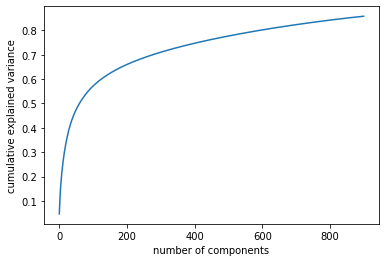

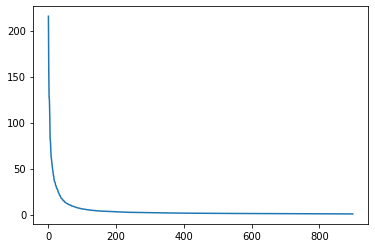

Original data dimension: (3615, 4608)
Data dimension after PCA: (3615, 900)


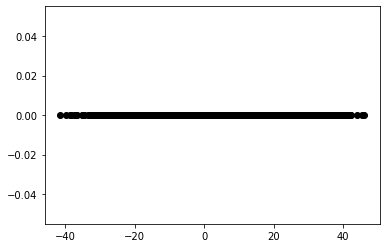

0.708
[[409 157]
 [135 299]]
48


In [ ]:
data, labels, confs = format_data(train_data1, train_data2)
data.fillna(data.mean(), inplace=True)
data_norm=normalize(data)
pca = PCA(n_components=900)
pca.fit(data_norm)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.figure()
plt.plot(pca.explained_variance_)

plt.show()
data_reduced = pca.fit_transform(data_norm)
# Same number of samples, different (reduced) number of features
print(f"Original data dimension: {data_norm.shape}")
print(f"Data dimension after PCA: {data_reduced.shape}")

# As we only have one dimension, as second dimension we use all 0
plt.figure()
plt.scatter(data_reduced, np.zeros((len(data_reduced),900)),c='k'); # in black

plt.show()

data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation, data_test, classes_test, confs_test = train_validation_split(data_reduced, labels, confs)

#MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100), activation='relu', solver='sgd', learning_rate_init=0.01, nesterovs_momentum=True, momentum=0.9)
mlp_clf.fit(data_train, classes_train)
preds = mlp_clf.predict(data_validation)
accuracy = accuracy_score(classes_validation, preds)
CM=confusion_matrix(classes_validation, preds)
print(accuracy)
print(CM)
print(mlp_clf.n_iter_)

# Using a Random Forest Classifier to try and incorporate the confidences into the model

### Feature Selection using Random Forest Classifier Feature Importances

- Display the feature importances and sort descending
- Choose the first 100 most 'important' features


0.732
0.7644359464627151
0.739
0.8458891013384321
0.738
0.8543021032504781
0.736
0.8604206500956023
0.74
0.8661567877629063
0.737
0.8780114722753346
0.737
0.8906309751434034
0.734
0.9074569789674952
accuracy of each fold - [0.7361830512094836, 0.7459817375981203, 0.7455545469108774, 0.7424307150104128, 0.746862818390559, 0.7428579056976556, 0.74240401559246, 0.7393068831099482]
Avg accuracy : 0.7426977091899396


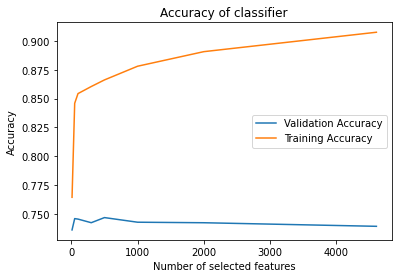

In [ ]:

from sklearn.impute import KNNImputer
data, labels, confs = format_data(train_data1, train_data2)
data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(data, labels, confs)
#Train a model using all of the data to find the feature importances
#data_KNN = KNNImputer().fit_transform(data)
data = pd.DataFrame(data)
data = data.fillna(data.mean(axis=0))
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_leaf=5)
rf_clf.fit(data, labels, sample_weight=confs)

train_score=[]
val_score=[]
num_features = [10,50,100,300,500,1000,2000,4608]
for i in num_features:
  #Find the feature importances from the classifier 
  data = pd.DataFrame(data)
  
  feature_imps = pd.Series(rf_clf.feature_importances_, index=data.columns)
  #Sort the feature importances in descending value
  sorted_feature_imps = feature_imps.sort_values(ascending=False)
  #Use the first 100 most important features
  feature_imps2 = sorted_feature_imps[:i]
  #Find the indices for the most important features
  selected_indices = feature_imps2.index.values
  #Select the data from the non KNN dataset using only the most important features
  #selected_columns = data.columns[selected_indices]
  selected_data = data[selected_indices]

  #Convert to numpy for the model
  selected_data = selected_data.to_numpy()

  #Train/Test/Val split on data with selected features
  data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(selected_data, labels, confs)
  #Fill in the missing values in the data
  data_train = pd.DataFrame(data_train)
  data_validation = pd.DataFrame(data_validation)
  data_train = data_train.fillna(data_train.mean(axis=0))
  data_validation = data_validation.fillna(data_validation.mean(axis=0))
  data_train = data_train.to_numpy()
  data_validation = data_validation.to_numpy()
  
     
  #Initialise the model
  rf = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_leaf=5, max_features='log2')
  #Fit the model 
  rf.fit(data_train, classes_train, sample_weight=confs_train)
  print(rf.score(data_validation, classes_validation))
  val_score.append(rf.score(data_validation, classes_validation, confs_validation))
  print(rf.score(data_train, classes_train))
  train_score.append(rf.score(data_train, classes_train))

avg_acc = np.mean(val_score)
print('accuracy of each fold - {}'.format(val_score))
print('Avg accuracy : {}'.format(avg_acc))
plt.plot(num_features, val_score, label="Validation Accuracy")
plt.plot(num_features, train_score, label="Training Accuracy")

plt.xlabel('Number of selected features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy of classifier')
plt.show()

accuracy of each fold - [0.7817679558011049, 0.7375690607734806, 0.7099447513812155, 0.7044198895027625, 0.7209944751381215, 0.6759002770083102, 0.7506925207756233, 0.7479224376731302, 0.7451523545706371, 0.7119113573407202]
Avg accuracy : 0.7286275079965105


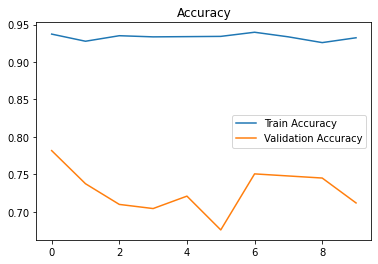

In [ ]:
def model_test_withPCA(num_comps):
  data, labels, confs = format_data(train_data1, train_data2)
  training_data = normalize(data)
  #Use PCA to transform the data
  pca = PCA(n_components=num_comps)
  training_data = pca.fit_transform(training_data)
  k=10
  kf = KFold(n_splits=k, random_state=None)
  model = RandomForestClassifier(max_depth=10)
  train_acc = []
  val_acc=[]
  #Cross validation
  for train_index , test_index in kf.split(training_data):
      data_train , data_validation = training_data[train_index],training_data[test_index]
      classes_train , classes_validation = labels[train_index] , labels[test_index]
      confs_train, confs_validation = confs[train_index], confs[test_index]
      #Impute missing values
      data_train = data_train.fillna(0)
      data_validation = data_validation.fillna(0)

      
      model.fit(data_train, classes_train, sample_weight=confs_train)
      

      acc = model.score(data_validation, classes_validation)
      val_acc.append(acc)
      acc = model.score(data_train, classes_train)
      train_acc.append(acc)
      
  avg_acc_score = sum(val_acc)/k
  

  print('accuracy of each fold - {}'.format(val_acc))
  print('Avg accuracy : {}'.format(avg_acc_score))
  plt.plot(train_acc, label='Train Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend()
  plt.title('Accuracy')
  plt.show()


model_test_withPCA()

Selecting features based on importance using SKLearn wrapper

Score using feature selection with 10 features 0.7010309278350515
Score using feature selection with 10 features 0.65625
Score using feature selection with 10 features 0.75
Score using feature selection with 10 features 0.8229166666666666
Score using feature selection with 10 features 0.8020833333333334
Score using feature selection with 10 features 0.7083333333333334
Score using feature selection with 10 features 0.71875
Score using feature selection with 10 features 0.7916666666666666
Score using feature selection with 10 features 0.8333333333333334
Score using feature selection with 10 features 0.71875
Score using feature selection with 50 features 0.7525773195876289
Score using feature selection with 50 features 0.6666666666666666
Score using feature selection with 50 features 0.78125
Score using feature selection with 50 features 0.8541666666666666
Score using feature selection with 50 features 0.8229166666666666
Score using feature selection with 50 features 0.75
Score using feat

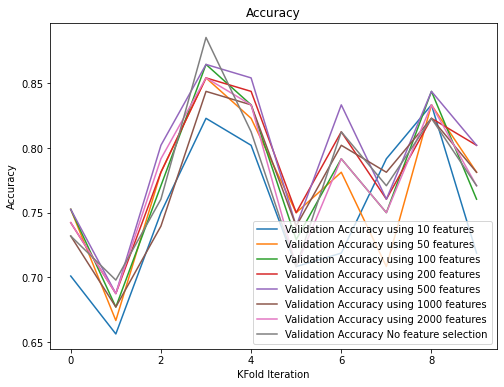

In [172]:
def feature_selectionCV(train_data1, train_data2, num_features):
  '''
  This function explores different levels of feature selection using both datasets where the confidence score is 1'''
    from sklearn.feature_selection import SelectFromModel

    #Select data with confidence 1 in the labels
    train1 = train_data1.loc[train_data1['confidence']==1]
    train2 = train_data2.loc[train_data2['confidence']==1]
    data, labels, confs = format_data(train1, train2)
    #data, labels, confs = format_data(train_data1, train_data2)
    train_acc=[]
    val_acc=[]
    imp_val_acc=[]
    imp_train_acc=[]
    data = data.to_numpy()
    #Set up our KFold cross-validator
    kf=KFold(n_splits=10, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(data):
      #Assign training and validation data
      data_train , data_validation = data[train_index],data[test_index]
      classes_train , classes_validation = labels[train_index] , labels[test_index]
      confs_train, confs_validation = confs[train_index], confs[test_index]
    
      #Impute missing values with 0
      data_train = pd.DataFrame(data_train)
      data_validation = pd.DataFrame(data_validation)
      data_train = data_train.fillna(0)
      data_validation = data_validation.fillna(0)
      data_train = data_train.to_numpy()
      data_validation = data_validation.to_numpy()

      #Set up the classifier and train using the full feature array
      model = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, max_features='sqrt')
      model.fit(data_train, classes_train)
      #Using SelectFromModel, select the most important features, and transform the data accordingly
      sel = SelectFromModel(model, max_features=num_features)
      sel.fit(data_train, classes_train)
      indices = sel.get_support(indices=True)

      imp_data_train = sel.transform(data_train)
      imp_data_val = sel.transform(data_validation)


      #print('Score without feature selection: ', model.score(data_validation, classes_validation))

      val_acc.append(model.score(data_validation, classes_validation))
      train_acc.append(model.score(data_train, classes_train))
      
      #Set up the new classifier with the transformed data and evaluate it's performance on the validation dataset. 
      imp_model = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, max_features='sqrt')
      imp_model.fit(imp_data_train, classes_train)
      print('Score using feature selection with {} features'.format(num_features), imp_model.score(imp_data_val, classes_validation))

      acc = imp_model.score(imp_data_val, classes_validation)
      imp_val_acc.append(acc)
      acc = imp_model.score(imp_data_train, classes_train)
      imp_train_acc.append(acc)

    return val_acc, train_acc, imp_val_acc, imp_train_acc

num_features=[10,50,100,200,500,1000,2000]
plt.figure(figsize=(8,6))
selected_accuracy = {}
for i in num_features:
  val_acc, train_acc, imp_val_acc, imp_train_acc=feature_selectionCV(train_data1, train_data2, i)
  avg_acc_score=np.mean(val_acc)
  #print('accuracy of each fold - {}'.format(val_acc))
  #print('Avg accuracy : {}'.format(avg_acc_score))
  #plt.plot(train_acc, label='Train Accuracy No Feature selection')
  title='Validation Accuracy using {} features'.format(i)
  selected_accuracy[i]=imp_val_acc
  #plt.plot(imp_train_acc, label='Train accuracy using feature selection')
  plt.plot(imp_val_acc, label=title)
plt.plot(val_acc, label='Validation Accuracy No feature selection')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('KFold Iteration')
#plt.ylim(top=1, bottom=0.5)
#plt.xlim(left=1, right=10)
plt.title('Accuracy')
plt.show()

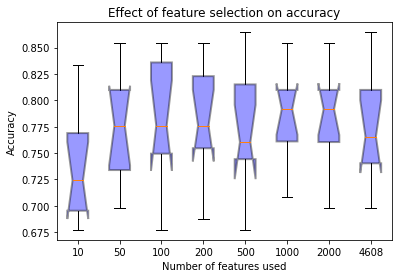

In [170]:
#Visualise the feature selection
plt.boxplot([ selected_accuracy[10], selected_accuracy[50], selected_accuracy[100], selected_accuracy[200], selected_accuracy[500], selected_accuracy[1000], selected_accuracy[2000], val_acc], showfliers=True, patch_artist=True , notch=True, boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4))
plt.title('Effect of feature selection on accuracy')
plt.xticks(ticks=[1,2,3,4,5,6,7,8], labels=[10,50,100,200,500,1000,2000,4608])
plt.ylabel('Accuracy')
plt.xlabel('Number of features used')
plt.show()

# Using GridSearch to tune the hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

data, labels, confs = format_data(train_data1, train_data2)
data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(data, labels, confs)
data_train.fillna(data_train.mean(axis=0), inplace=True)
data_validation.fillna(data_train.mean(axis=0), inplace=True)
grid_search = {
               'max_depth': list(np.linspace(5, 20, 5, dtype = int)) + [None],
               'max_features': ['log2'],
               'min_samples_leaf': [1,2],
               'min_samples_split': [2,5, 10,],
               'n_estimators': [10, 50,100,500]}


clf = RandomForestClassifier()
model = GridSearchCV(estimator = clf, param_grid = grid_search, 
                               cv = 4, verbose= 5, n_jobs = 1)
model.fit(data_train,classes_train, sample_weight=confs_train)

predictionforest = model.best_estimator_.predict(data_validation)
print(confusion_matrix(classes_validation,predictionforest))
print(classification_report(classes_validation,predictionforest))
acc4 = accuracy_score(classes_validation,predictionforest)

# Experiment with hyper parameters

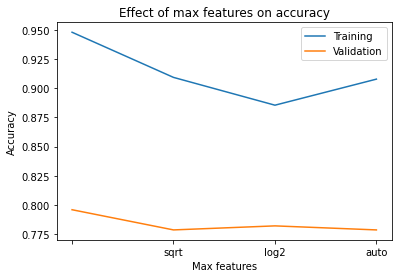

In [207]:
'''
#Using confidence 1 on both datasets
train1 = train_data1.loc[train_data1['confidence']==1]
train2 = train_data2.loc[train_data2['confidence']==1]
data, labels, confs = format_data(train1, train2)
#Train/validation split
data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(data, labels, confs)
#Impute missing values
data_train = data_train.fillna(0)
data_validation = data_validation.fillna(0)

train_score=[]
val_score=[]

#Hyperparameters
min_samples_leafs=[1,2,5,10,15,20,30,40,50]
max_depths=[None, 2,5,10,15,20,50,70,100]
estimators=[10,50,100,500,1000]
min_samples_splits=[2,3,5,10,15]
max_feats=[None, 'sqrt', 'log2', 'auto']
for i,val  in enumerate(max_feats):
  rf = RandomForestClassifier(n_estimators=500,max_depth=5, min_samples_leaf=3, min_samples_split=10, max_features=val)
  rf.fit(data_train, classes_train)
  acc=rf.score(data_train, classes_train)
  train_score.append(acc)
  acc=rf.score(data_validation, classes_validation)
  val_score.append(acc)
  print('Max features: {} '.format(val), 'Accuracy: {}'.format(acc))
'''

plt.plot( train_score, label='Training')
plt.plot(val_score, label="Validation")
plt.xlabel('Max features')
plt.ylabel('Accuracy')
plt.xticks(ticks=np.arange(0,4), labels=max_feats)
plt.title('Effect of max features on accuracy')
plt.legend()
plt.show()

# Using both datasets with confidence=1

In [193]:
train1 = train_data1.loc[train_data1['confidence']==1]
train2 = train_data2.loc[train_data2['confidence']==1]
data, labels, confs = format_data(train1, train2)
data = np.array(data)
labels = np.array(labels)
confs=np.array(confs)

kf = KFold(n_splits=10, random_state=42, shuffle=True)
model = RandomForestClassifier(n_estimators=500, max_depth=10,min_samples_split=5,max_features='log2')
both = []
both_train = []
 
for train_index , test_index in kf.split(data):
    data_train , data_validation = data[train_index],data[test_index]
    classes_train , classes_validation = labels[train_index] , labels[test_index]
    confs_train, confs_validation = confs[train_index], confs[test_index]
    data_train, data_validation = preprocess(data_train, data_validation)

     
    model.fit(data_train, classes_train, sample_weight=confs_train)
     
    acc = model.score(data_validation, classes_validation)
    both.append(acc)
    acc = model.score(data_train, classes_train)
    both_train.append(acc)
     
avg_acc_score = sum(both)/10
 
print('accuracy of each fold - {}'.format(both))
print('Avg accuracy : {}'.format(avg_acc_score))
plt.plot(both, label="Validation Accuracy")
plt.plot(both_train, label="Training Accuracy")
plt.legend()
plt.title('Accuracy using both datasets where confidence=1')
plt.show()

KeyboardInterrupt: ignored

# Using both datasets with confidence scores

accuracy of each fold - [0.7209944751381215, 0.7375690607734806, 0.7624309392265194, 0.7734806629834254, 0.7569060773480663, 0.7257617728531855, 0.7562326869806094, 0.7229916897506925, 0.7590027700831025, 0.6952908587257618]
Avg accuracy : 0.7410660993862964


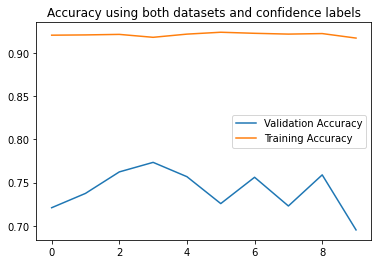

In [ ]:
data, labels, confs = format_data(train_data1, train_data2)
data = np.array(data)
labels = np.array(labels)
confs=np.array(confs)

kf = KFold(n_splits=10, random_state=42, shuffle=True)
model = RandomForestClassifier(n_estimators=500, max_depth=10,min_samples_split=5,max_features='log2')
conf_both = []
conf_both_train = []
 
for train_index , test_index in kf.split(data):
    data_train , data_validation = data[train_index],data[test_index]
    classes_train , classes_validation = labels[train_index] , labels[test_index]
    confs_train, confs_validation = confs[train_index], confs[test_index]
    #data_train, data_validation = preprocess(data_train, data_validation)
    data_train = pd.DataFrame(data_train)
    data_validation = pd.DataFrame(data_validation)
    data_train = data_train.fillna(data_train.mean(axis=0))
    data_validation = data_validation.fillna(data_validation.mean(axis=0))
    data_train = data_train.to_numpy()
    data_validation = data_validation.to_numpy()
    
     
     
    model.fit(data_train, classes_train, sample_weight=confs_train)
     
    acc = model.score(data_validation, classes_validation)
    conf_both.append(acc)
    acc = model.score(data_train, classes_train)
    conf_both_train.append(acc)
     
avg_acc_score = sum(conf_both)/10
 
print('accuracy of each fold - {}'.format(conf_both))
print('Avg accuracy : {}'.format(avg_acc_score))
plt.plot(conf_both, label="Validation Accuracy")
plt.plot(conf_both_train, label="Training Accuracy")
plt.legend()
plt.title('Accuracy using both datasets and confidence labels')
plt.show()

# Using only data from first dataset with confidences

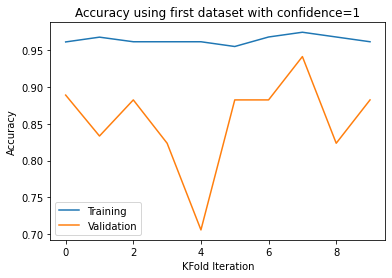

In [ ]:
train_conf1 = train1[train1.columns[4609]]
train_label1 = train1[train1.columns[4608]]
train = train1.iloc[:,:4608]
data_cf=train.to_numpy()
label_cf=train_label1.to_numpy()
confs_cf=train_conf1.to_numpy()

kf=KFold(n_splits=10, shuffle=True, random_state=42)

conf_first = []
conf_first_train = []

for train_index , test_index in kf.split(data_cf):

  confs_train, confs_validation = confs_cf[train_index], confs_cf[test_index]
  data_train , data_validation = data_cf[train_index],data_cf[test_index]
  classes_train , classes_validation = label_cf[train_index] , label_cf[test_index]

      
  rf = RandomForestClassifier(n_estimators=500,max_depth=10, min_samples_leaf=5, min_samples_split=5, max_features='log2')
  rf.fit(data_train, classes_train)
  
  acc=rf.score(data_train, classes_train)
  conf_first_train.append(acc)
  acc=rf.score(data_validation, classes_validation)
  conf_first.append(acc)

avg_acc_score = sum(conf_first)/10
print('accuracy of each fold - {}'.format(conf_first))
print('Avg accuracy : {}'.format(avg_acc_score))
plt.plot(conf_first_train, label='Training')
plt.plot(conf_first, label="Validation")
plt.xlabel('KFold Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy using first dataset with confidence=1')
plt.legend()
plt.show()

# Using only data with label confidence = 1 from first dataset

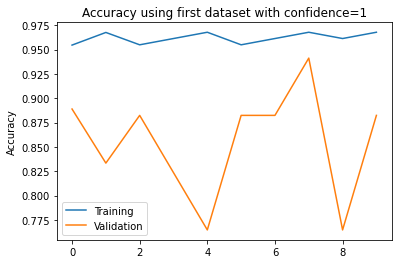

In [ ]:
#Only select rows of data if the confidence is 1
train1 = train_data1.loc[train_data1['confidence']==1]
train_conf1 = train1[train1.columns[4609]]
train_label1 = train1[train1.columns[4608]]
#train = train1.iloc[:,:4608]

data_cf=train.to_numpy()
label_cf=train_label1.to_numpy()
confs_cf=train_conf1.to_numpy()

kf=KFold(n_splits=10, shuffle=True, random_state=42)

first = []
first_train = []

for train_index , test_index in kf.split(data_cf):

  confs_train, confs_validation = confs_cf[train_index], confs_cf[test_index]
  data_train , data_validation = data_cf[train_index],data_cf[test_index]
  classes_train , classes_validation = label_cf[train_index] , label_cf[test_index]

      
  rf = RandomForestClassifier(n_estimators=100,max_depth=5, min_samples_leaf=5, min_samples_split=2, max_features='log2')
  rf.fit(data_train, classes_train)
  
  acc=rf.score(data_train, classes_train)
  first_train.append(acc)
  acc=rf.score(data_validation, classes_validation)
  first.append(acc)

  
plt.plot(first_train, label='Training')
plt.plot(first, label="Validation")
plt.ylabel('Accuracy')
plt.title('Accuracy using first dataset with confidence=1')
plt.legend()
plt.show()

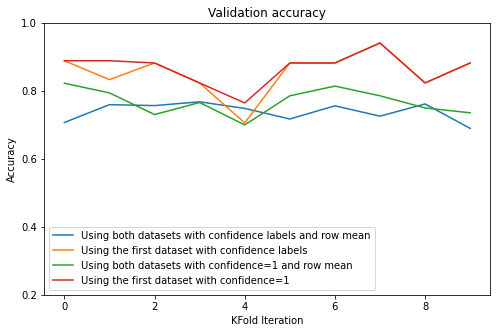

In [ ]:
#Plot the results of the above experiments to compare the effect of the confidence scores and both datasets 
plt.figure(figsize=(8,5))
plt.title('Validation accuracy')
plt.plot(conf_both, label='Using both datasets with confidence labels and row mean')
plt.plot(conf_first, label='Using the first dataset with confidence labels')
plt.plot(both, label='Using both datasets with confidence=1 and row mean')
plt.plot(first, label='Using the first dataset with confidence=1')
plt.xlabel('KFold Iteration')
plt.ylabel('Accuracy')
plt.yticks(ticks=[0.2, 0.4, 0.6, 0.8, 1.0], label=[0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend()
plt.show()

# Using only GIST features vs Using only CNN features

In [ ]:
data, labels, confs = format_data(train_data1, train_data2)

#Using CNN Features only
data = data.iloc[:,:4096]
#Using GIST Features only
#data = data.iloc[:,4096:]
data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(data, labels, confs)
data_train = pd.DataFrame(data_train)
data_validation = pd.DataFrame(data_validation)
data_train = data_train.fillna(data_train.median(axis=0))
data_validation = data_validation.fillna(data_train.(axis=0))
data_train = data_train.to_numpy()
data_validation = data_validation.to_numpy()

model = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, bootstrap=True, oob_score=True, max_depth=10, max_features='sqrt' )
model.fit(data_train, classes_train, sample_weight=confs_train)
model.score(data_validation, classes_validation)
#data

0.744

# Making predictions on the test set

In [209]:
#Since the model is trained using data only with confidence 1
train1 = train_data1.loc[train_data1['confidence']==1]
train2 = train_data2.loc[train_data2['confidence']==1]
data, labels, confs = format_data(train1, train2)
data=data.fillna(0)

#Split the data to train/validation
data_train, classes_train, confs_train, data_validation, classes_validation, confs_validation = train_validation_split(data, labels, confs)
test = test_data.fillna(0)

#Training the model
model = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, max_features='sqrt')
model.fit(data_train, classes_train, sample_weight=confs_train)
#Select the best features
sel = SelectFromModel(model, max_features=500)
sel.fit(data_train, classes_train)
indices = sel.get_support(indices=True)

#Transform the train,validation and test data to use the top 500 features
imp_data_train = sel.transform(data_train)
imp_data_val = sel.transform(data_validation)
imp_data_test = sel.transform(test)

#Fit a new classifier to the transformed feature selected data
model2 = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True, max_features='sqrt')
model2.fit(imp_data_train, classes_train)
print(model2.score(imp_data_val, classes_validation))
print(confusion_matrix(classes_validation, model2.predict(imp_data_val)))


indices = sel.get_support(indices=True)
#Make the predictions on the feature selected test data
test_predictions = model2.predict(imp_data_test)
prediction = pd.DataFrame(test_predictions, columns=['predictions']).to_csv('/content/drive/My Drive/Colab Notebooks/Fundamentals of Machine Learning/FML Assignment/predictions.csv')

print(test_predictions)


0.7785467128027682
[[106  28]
 [ 36 119]]
[1. 0. 1. ... 0. 1. 0.]
